# Machine Learning Engineer Nanodegree
## Capstone Project
Andres Mechali

May 13th, 2017

## I. Definition

### Project Overview

This project is taken from the Kaggle platform, and is currently available under the name _Quora Question Pairs_ in this link: https://www.kaggle.com/c/quora-question-pairs. Quora is a platform where anyone can make a question, and other users give answers. According to Quora, they receive over 100 million visits every month, so it's very common that the question someone asks has already been answered by others. In order to make it easier for someone to find an answer, they use a Random Forest model to identify duplicate questions.

This project is about finding a model that can determine wether a pair of questions has the same meaning or not. The input data is a dataset of about 400,000 pair of questions with a human provided label stating if they have the same meaning. As for testing, Kaggle provides a set of unlabeled pairs, which are then compared to their own human labeled results.

### Problem Statement
In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_

FALTA

### Metrics

The metrics that I will use for measuring the performance of the models will be the log-loss. This is a very commonly used metrics in models where the output is the probability of a binary outcome, which is the case of this project. This metrics penalize wrong classifications depending on how confident the model was about them. Specifically, a prediction with a greater level of confidence is more penalized when wrong.

Another reason for choosing log-loss as a metrics is because it is the one used in the Kaggle platform to evaluate the predictions. So, by using this while training, I can compare the results with other Kaggle users.

## II. Analysis

### Data Exploration

First of all, I need to import the basic libraries.

In [392]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

Now I will import the training set, and display the first 5 lines.

In [186]:
data_train = pd.read_csv('data/train.csv')
data_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In this dataset we can find the following information:
* qid1: Unique ID of question 1
* qid2: Unique ID of question 2
* question1: Content of question 1
* question2: Content of question 2
* is_duplicate: A label stating if both questions are the same (1) or not (0)

Next, I will display some basic statistics about the dataset.

In [4]:
print("Number of rows: %d" %len(data_train))
dup = data_train[data_train.is_duplicate == 1]
n_dup = data_train[data_train.is_duplicate == 0]
print("Duplicate pair of questions: %d" %len(dup))
print("Not duplicate pair of questions: %d" %len(data_train[data_train.is_duplicate == 0]))

qids = data_train.qid1.tolist() + data_train.qid2.tolist()
print("Unique questions: %d" %len(set(qids)))

Number of rows: 404290
Duplicate pair of questions: 149263
Not duplicate pair of questions: 255027
Unique questions: 537933


### Exploratory Visualization

Now I will do a brief analysis of the questions in the training set. I will use the Natural Language Tool Kit (nltk) for this, and I will display an histogram to see the frequency of the lengths of the questions.

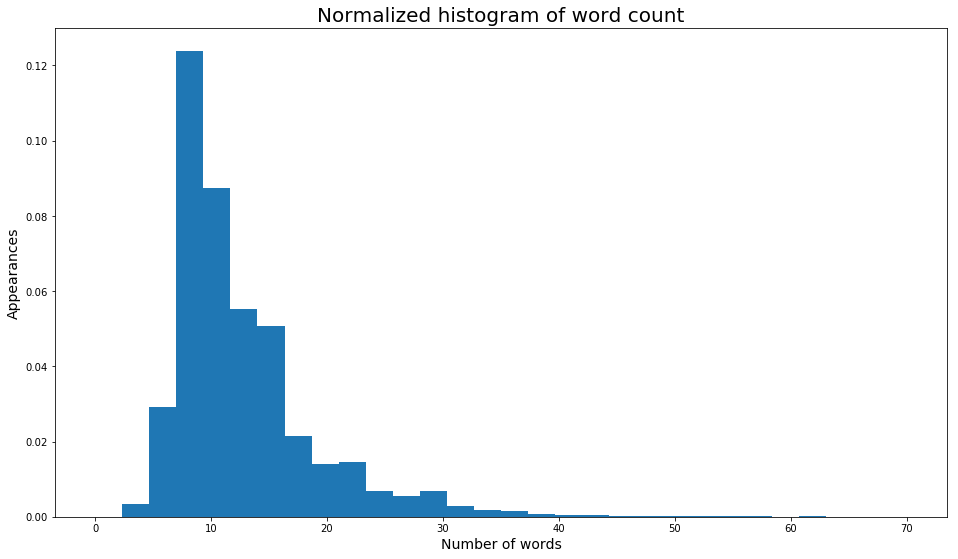

In [5]:
import nltk

q_tok = []
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question1.apply(lambda x: str(x).decode('utf-8'))]
q_tok += [nltk.tokenize.word_tokenize(i) for i in data_train.question2.apply(lambda x: str(x).decode('utf-8'))]

word_count = [len(i) for i in q_tok]

plt.figure(figsize=(16,9))
plt.hist(word_count, bins=30, range=[0,70], normed=True)
plt.title("Normalized histogram of word count", fontsize=20)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Appearances", fontsize=14)
plt.show()

As we might see here, most of the questions are composed from about 8 to 12 words. There are some of them which can have even more than 50 words. I will not exclude these outliers, because when comparing lengths I will use the absolute value, and not a normalized one. Hence, outliers should not affect my outcome. 

### Algorithms and Techniques

For this project I will evaluate 3 algorithms: AdaBoost, Random Forest and XGBoost. The reason for this is that they are all ensemble methods, which work well for problems where the features are weak learners. In this problem all the features will be so, because there doesn't seem to be one that is highly correlated with the meaning of the question.

I will try the 3 models and determine which has the minimum log-loss. After that, I will tune this model to find the best possible parameters for this problem.

### Benchmark: Naive predictor
As a Benchmark for testing the effectiveness of this model, I will use a predictor that evaluates if two questions are equal just based on the probability of this happening. I will assign this same probability to every pair of questions. I will upload this result to the Kaggle platform an evaluate the log-loss obtained. This will be my benchmark to see if I can obtain a better model for this.

In [6]:
prob = data_train.is_duplicate.mean()

data_test = pd.read_csv("data/test.csv")

In [9]:
submission = pd.DataFrame(data_test.test_id)

In [14]:
test_is_duplicate = []

for i in range(len(submission.test_id)):
    test_is_duplicate.append(prob)

In [15]:
submission['is_duplicate'] = test_is_duplicate
submission.head()

,test_id,is_duplicate
0,0,0.369198
1,1,0.369198
2,2,0.369198
3,3,0.369198
4,4,0.369198


In [16]:
submission.to_csv('sub/naive_predictor.csv', index=False)

The log-loss obtained was **0.55411**. This will be used as a benchmark, and any model with a lower value will be considered better.

In [17]:
del submission

## III. Methodology

### Data Preprocessing

I will now pre process the raw data, for which I will need a series of steps stated below:

* Removing stop words: The first step will be to remove all words that are considered not to give valuable information about the content of the question. Examples of this will be _you_, _have_, _the_, _to_, etc., and punctuation.
* Applying stemming: In order to consider the same word _car_ and _cars_, I will apply a stemming algorithm that keeps the root of each word.
* Tokenize: I will split questions into list of words, so that I can loop and compare them easily.
* Tf-Idf: With this I will consider the importance of a word related to it's frequency, instead of considering them equal. The fact that 2 question share a word that appears often will be less important than if they share a rare word.
* DiffLib: This is a Python library that will help me finding differences between 2 strings. Specifically, I will be using the SequenceMatcher method.

By doing these steps, I will get a new set of features, which will be composed of:
* shared_weights: a measure of how many words both questions share, weighted by the tf-idf value of each word.
* shared_count_scaled: it will represent the normalized amount of words that they have in common.
* len_dif: the difference between the lengths of the questions.
* z_match_ratio: the value obtained from the SequenceMatcher method.

I will also check if these features seem relevant to classify between equal and unequal questions. For this, I will use histograms.


In [187]:
data_train = data_train[0:10000]

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

First, I will define all the functions that I will use for preprocessing.

###### Removing stop words and applying stemming.

In [19]:
# Import libraries
from nltk.stem.snowball import SnowballStemmer
import re
from nltk.corpus import stopwords

# Define stemmer method and stop words
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) # Adds punctuation to stopwords


def cleanQuestions(q_list):
    clean_questions = []

    for i in range(len(q_list)):
        q1 = ''
        for j in re.findall(r"[\w']+", str(q_list[i])):
            if j not in stop_words:
                q1 += stemmer.stem(j)
                q1 += " "
        q = ''
        for j in q1.split(): # Because the first words where not taken before
            if j not in stop_words:
                q += j
                q += " "
        clean_questions.append(q.strip()) # To remove the last blank space
        
    return clean_questions

###### Tf-Idf

Now I will apply a TF-IDF model in order to get the relative importance of each word. In this way, words which appear more often will be less important than words that appear less.

First, I need to identify the unique questions, because some of them are repeated in the dataset and otherwise would generate a different result.

In [34]:
def uniqueQuestions():
    questions = []

    for i in tqdm(range(len(questions1_clean))):
        questions.append(str(questions1_clean[i]))
        questions.append(str(questions2_clean[i]))
    
    questions = set(questions)

    print("There are %d unique questions in the dataset." %len(questions))
    
    return questions

In [21]:
def tfIdfVectorizer(questions):
    # Import the library
    from sklearn.feature_extraction.text import TfidfVectorizer
    # Obtain the Tf-Idf value of each word, using the TfidfVectorizer function from sklearn
    vectorizer = TfidfVectorizer(max_df=0.5)
    tfidf = vectorizer.fit_transform(questions)
    idf = vectorizer.idf_
    # Create and return a dictionary with every word as a key, and its respective weight as a value
    return dict(zip(vectorizer.get_feature_names(), idf))

###### Tokenize

In [23]:
def tokenizeQuestions(q):
    return [nltk.tokenize.word_tokenize(i) for i in q]

###### Getting the weighted percentage of shared words

First, I need a list of the shared words, and a list of all the words for each pair

In [24]:
def sharedWords(q1, q2):
    shared_words = []
    total_words = []

    for i in tqdm(range(len(q1))):
        shared = []
        total = []
        for w in q1[i]:
            total.append(w)
            if w in q2[i]:
                shared.append(w)
        for w in q2[i]:
            total.append(w)
            if w in q1[i]:
                shared.append(w)
        shared_words.append(shared)
        total_words.append(total)
    return shared_words, total_words

I will now create 2 new lists with the shared and total weights, using the idf dictionary created before.

In [60]:
def sharedWeights(shared_words):
    shared_weights = []
    total_weights = []
    not_in_dict = []
    for i in tqdm(range(len(shared_words))):
        shared = []
        total = []
        for w in shared_words[i]:
            try:
                shared.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        for w in total_words[i]:
            try:
                total.append(idf_dict[w])
            except:
                not_in_dict.append(w)
                shared.append(0)
        shared_weights.append(shared)
        total_weights.append(total)
    return shared_weights, total_weights

Finally, I need a list that has the sum of all the shared weights divided by the sum of all the weights for each pair of questions.

In [206]:
def getWeights(shared_weights):
    weights = []
    for i in range(len(shared_weights)):
        shared = 0
        total = 0
        for j in range(len(shared_weights[i])):
            shared += shared_weights[i][j]
        for j in range(len(total_weights[i])):
            total += total_weights[i][j]
        if total == 0:
            weights.append(0)
        else:
            weights.append(shared / total)
    return weights

###### I will now apply these transformations to the training dataset.

In [193]:
questions1 = data_train.question1.tolist()
questions2 = data_train.question2.tolist()

questions1_clean = cleanQuestions(questions1)
questions2_clean = cleanQuestions(questions2)

questions = uniqueQuestions()

100%|████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 624998.73it/s]


There are 18669 unique questions in the dataset.


In [194]:
idf_dict = tfIdfVectorizer(questions)

In [201]:
unique_tokens = [nltk.tokenize.word_tokenize(str(i)) for i in questions]

In [202]:
question1_token = tokenizeQuestions(questions1_clean)
print 'Questions 1 tokenized.'
question2_token = tokenizeQuestions(questions2_clean)
print 'Questions 2 tokenized.'

shared_words, total_words = sharedWords(question1_token, question2_token)

Questions 1 tokenized.
Questions 2 tokenized.


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 77519.41it/s]


In [203]:
shared_weights, total_weights = sharedWeights(shared_words)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 94339.46it/s]


In [207]:
weights = getWeights(shared_weights)

For each new feature that I create, I will plot the distribution of the duplicate and non duplicate questions, in order to see if this feature seems to be useful for predicting. I will start defining a function that will allow me to do this easier.

In [327]:
def plotDistribution(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(X[y['is_duplicate'] == 0][feature].tolist(), bins=20, normed=True, label='Not Duplicate')
    plt.hist(X[y['is_duplicate'] == 1][feature].tolist(), bins=20, normed=True, alpha=0.7, label='Duplicate')
    plt.legend()
    plt.title('Label distribution over ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

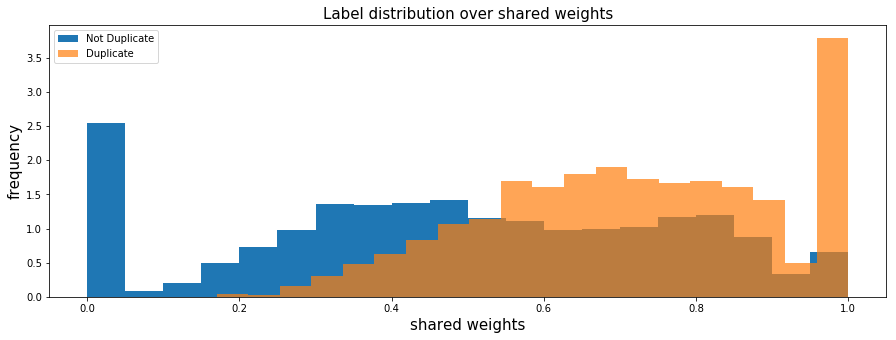

In [328]:
plotDistribution('shared_weights', 'shared weights')

This feature, **shared_weights**, looks to give some information about the equalness of a pair of questions.

I will start a new DataFrame and fill it with the features I create.

In [209]:
X = pd.DataFrame(weights, columns=['shared_weights'])
X.head()

,shared_weights
0,0.951107
1,0.628847
2,0.518414
3,0.000000
4,0.245394


The next feature I will generate will be the number of shared words in both questions.

In [356]:
shared_count = [len(x) for x in shared_words]

In order to see the distribution of this feature, I will plot an histogram. I will define a function that will allow me to do this easier for future features.

In [354]:
def plotHistogram(feature, desc):
    plt.figure(figsize=(15, 5))
    plt.hist(feature, bins=40)
    plt.title('Distribution of ' + desc, fontsize=15)
    plt.xlabel(desc, fontsize=15)
    plt.ylabel('frequency', fontsize=15)
    plt.show()

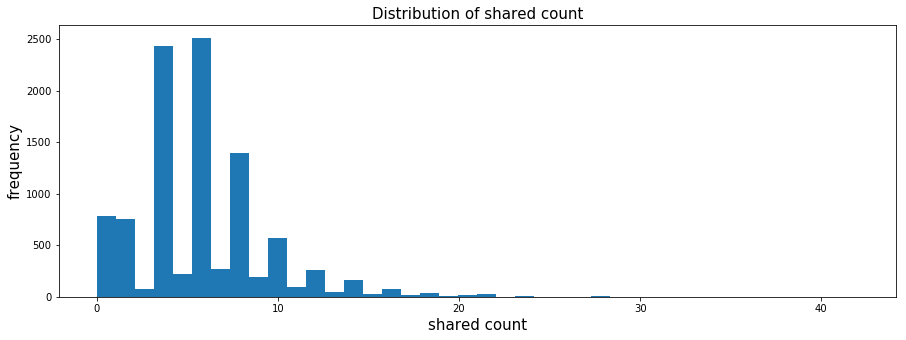

In [357]:
plotHistogram(shared_count, 'shared count')

In order to make it more relevant, I will use the MinMaxScaler function of sklearn, for scaling this feature before using it. As we can see in the prior histogram, most of the cases share 10 words or less, so including the ones with higher values will make this scaling to lose power. I will therefor consider all the cases with more than 10 shared words as if they had just 10.

In [358]:
from sklearn.preprocessing import MinMaxScaler

shared_count_cut = [x if x < 10 else 10 for x in shared_count]

shared_count_scaled = MinMaxScaler().fit_transform(np.array(shared_count_cut, dtype='float64').reshape(-1, 1))

X['shared_count_scaled'] = shared_count_scaled.reshape(-1, 1)

del shared_count, shared_count_cut, shared_count_scaled

X.head()

,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.951107,1.0,0.2,0.926829
1,0.628847,0.8,1.0,0.661871
2,0.518414,0.6,0.2,0.439394
3,0.000000,0.0,1.0,0.086957
4,0.245394,0.4,1.0,0.365217


To see how useful this feature is, I will use the function created before and analyze the plot.

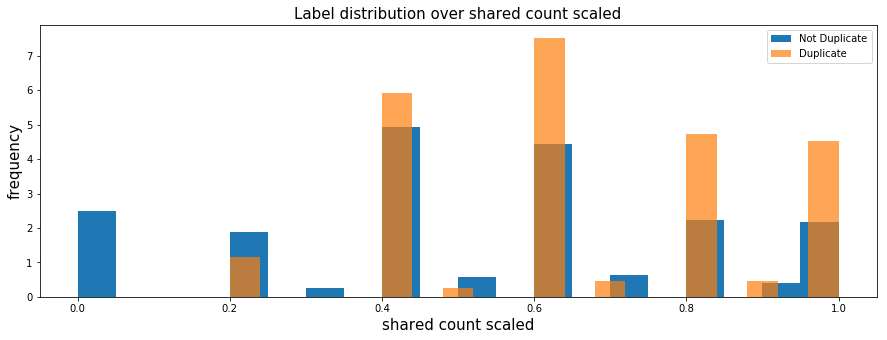

In [348]:
plotDistribution('shared_count_scaled', 'shared count scaled')

I can see that pairs with a higher value tend to be duplicated in more cases than the ones with lower values.

The next feature I will add is the difference in the length of the question. Again, I will scale it to get a value between 0 and 1.

In [365]:
question1_len = [len(x) for x in question1_token]
question2_len = [len(x) for x in question2_token]

len_dif = []

for i in range(len(question1_len)):
    len_dif.append(abs(question1_len[i] - question2_len[i]))

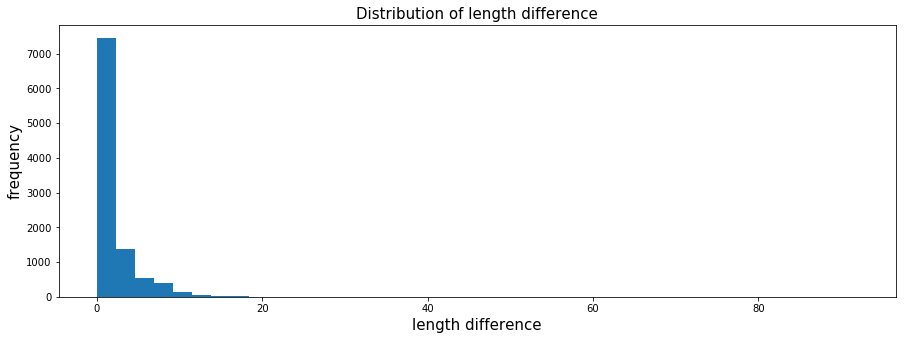

In [359]:
plotHistogram(len_dif, 'length difference')

I can see from this plot that most of the values are lower than 5, so again I will convert higher values to 5, and then rescale it with the MinMaxScaler method.

In [366]:
len_dif_cut = [5 if i > 5 else i for i in len_dif]
len_dif_cut = np.array(len_dif_cut).reshape(-1, 1)

len_dif_scaled = MinMaxScaler().fit_transform(len_dif_cut)

X['len_dif'] = len_dif_scaled

del len_dif, len_dif_cut

X.head()

,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.951107,1.0,0.2,0.926829
1,0.628847,0.8,1.0,0.661871
2,0.518414,0.6,0.2,0.439394
3,0.000000,0.0,1.0,0.086957
4,0.245394,0.4,1.0,0.365217


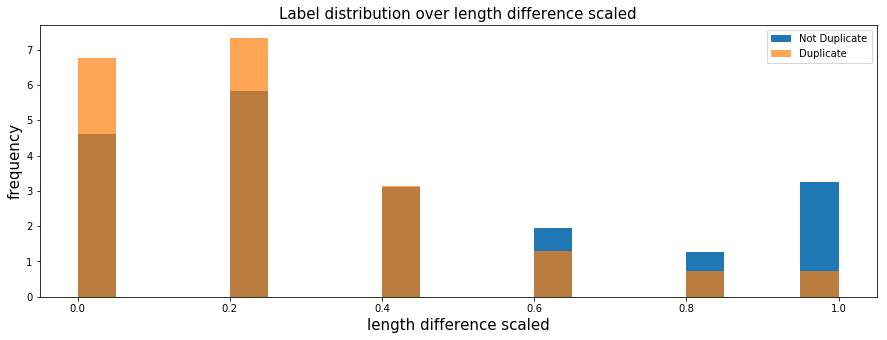

In [368]:
plotDistribution('len_dif', 'length difference scaled')

Again, this feature seems to be useful for predicting.

### DiffLib

In [369]:
import difflib

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

In [370]:
z_match_ratio = []

for i in tqdm(range(len(data_train))):
    z_match_ratio.append(diff_ratios(data_train.question1[i], data_train.question2[i]))
                         
X['z_match_ratio'] = z_match_ratio

X.head()

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2697.60it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.951107,1.0,0.2,0.926829
1,0.628847,0.8,1.0,0.661871
2,0.518414,0.6,0.2,0.439394
3,0.000000,0.0,1.0,0.086957
4,0.245394,0.4,1.0,0.365217


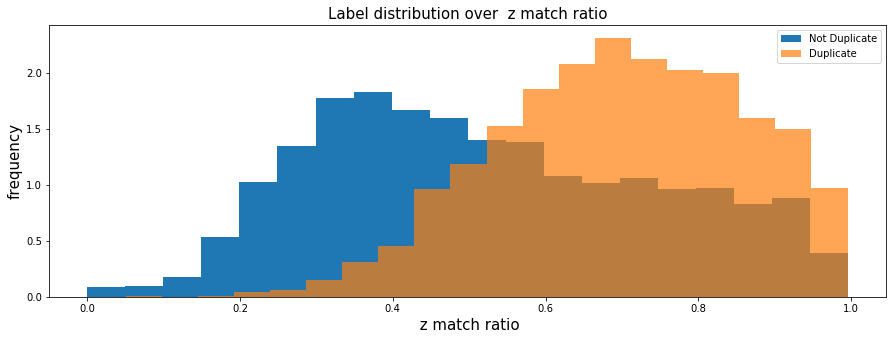

In [371]:
plotDistribution('z_match_ratio', ' z match ratio')

### Labels

In order to be able to test the algorithms, I will now generate a new DataFrame with the label for each pair of questions. This label will have value 0 if they don't mean the same, and 1 if they do.

In [372]:
y = pd.DataFrame(data_train.is_duplicate, columns=['is_duplicate'])

Finally, I will split the features and labels into a training and test set, in order to look for a good model. At the end, when I finally decide which to use, I will use the whole set for training, and I will test using the Kaggle testing set.

In [388]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

###### Model selection

Now that I have both the features that I will try, and the labels for each data point, I will start with the analysis of 3 different models which might obtain a good result: Random forest, AdaBoost and XGBoost.

In [378]:
from sklearn.metrics import log_loss

###### AdaBoost

In [389]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf = AdaBoostClassifier(random_state=50)
clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.663591


In [386]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', 
                            splitter='best', 
                            max_depth=None, 
                            min_samples_split=30, 
                            min_samples_leaf=30, 
                            min_weight_fraction_leaf=0.01, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_split=1e-07, 
                            class_weight=None, 
                            presort=False)

clf = AdaBoostClassifier(base_estimator=dt, n_estimators=5, learning_rate=0.5, random_state=50)
clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.547313


###### Random Forest

In [390]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=100)

clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.679992


In [412]:
from sklearn.ensemble import RandomForestClassifier

clf= RandomForestClassifier(n_estimators=100, 
                            criterion='gini', 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=2, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_split=1e-07, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=1, 
                            random_state=50, 
                            verbose=0, 
                            warm_start=False, 
                            class_weight=None)

clf.fit(x_train, np.ravel(y_train))

pred = clf.predict_proba(x_test)

print 'Log loss: %f' %log_loss(y_test, pred)

Log loss: 0.547233


###### XGBoost

In [180]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

In [377]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68746	test-logloss:0.687678
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.640941	test-logloss:0.643796
[20]	train-logloss:0.60812	test-logloss:0.612925
[30]	train-logloss:0.58394	test-logloss:0.590473
[40]	train-logloss:0.565784	test-logloss:0.573843
[50]	train-logloss:0.551673	test-logloss:0.561279
[60]	train-logloss:0.540699	test-logloss:0.551964
[70]	train-logloss:0.531942	test-logloss:0.544781
[80]	train-logloss:0.524989	test-logloss:0.539276
[90]	train-logloss:0.519556	test-logloss:0.534975
[99]	train-logloss:0.51567	test-logloss:0.532289


As we can see, the three models have a similar log-loss, so in order to determine which is potentially better, I should tune each of them to find the best possible parameters. In the next section, I will focus on that.

### Refinement

In order to find which is the best of the three models, I will tune them and see which one gives me the lowest log-loss. For tuning, I will use the GridSearchCV tool from the scikit-learn library.

In [391]:
from sklearn.model_selection import GridSearchCV

I will now define a function that will allow me to use GridSearchCV in a simpler way.

In [483]:
def gridSearch(clf, base=None, params={}, base_params={}):
    start = time.time()
    
    param_grid = dict()
    for i in params.keys():
        param_grid[i] = params[i]
    for i in base_params.keys():
        param_grid['base_estimator__' + i] = base_params[i]
    if base == None:
        pass
    else:
        clf = type(clf)(base_estimator=base, random_state=50)
    gs = GridSearchCV(clf, param_grid, scoring='neg_log_loss')
    gs.fit(x_train, np.ravel(y_train))
    
    end = time.time()
    
    pred = gs.predict_proba(x_test)
    print 'Time taken: %f seconds' %(end - start)
    print 'Log loss: %f' %log_loss(y_test, pred)
    best_params = [i + ': ' + str(gs.best_params_[i]) for i in gs.best_params_.keys()]
    print 'Best parameters:'
    if params != {}:
        print '   Classifier:'
        for i in range(len(params.keys())):
            print '      ' + best_params[i]
    if base_params != {}:
        print '   Base Estimator:'
        for i in range(len(base_params.keys())):
            print '      ' + best_params[i + len(params.keys())][16:]

For every model I will apply GridSearchCV to a series of parameters that I consider they have a bigger effect on log-loss. I tried every single parameter before, and given the results I chose these. In order to make it quicker, I will try them separately. If I put all of them together the search can take a very long time.

###### AdaBoost

In [473]:
gridSearch(AdaBoostClassifier(random_state=50), 
           base=DecisionTreeClassifier(), 
           base_params={'min_samples_split':[10, 30], 
                        'min_samples_leaf':[10, 30]})

Time taken: 11.520000 seconds
Log loss: 0.557928
Best parameters:
   Base Estimator:
      min_samples_split: 30
      min_samples_leaf: 30


In [481]:
gridSearch(AdaBoostClassifier(random_state=50),
          base=DecisionTreeClassifier(min_samples_split=30,
                                     min_samples_leaf=30),
           params={'n_estimators':[70, 50]},
           base_params={'min_weight_fraction_leaf': [0.0, 0.01]}
          )

Time taken: 23.626000 seconds
Log loss: 0.547105
Best parameters:
   Classifier:
      n_estimators: 70
   Base Estimator:
      min_weight_fraction_leaf: 0.0


In [484]:
gridSearch(AdaBoostClassifier(n_estimators=70, random_state=50),
          base=DecisionTreeClassifier(min_samples_split=30,
                                     min_samples_leaf=30,
                                     min_weight_fraction_leaf=0.0),
           params={'learning_rate':[0.1, 0.3, 0.5]})

Time taken: 20.736000 seconds
Log loss: 0.556870
Best parameters:
   Classifier:
      learning_rate: 0.5


The best log-loss that I can get from the AdaBoost algorithm is **0.55**.

###### Random Forest

In [487]:
gridSearch(RandomForestClassifier(random_state=50), 
          params={'n_estimators':[100, 200],
                 'min_samples_leaf': [5, 10]})

Time taken: 26.459000 seconds
Log loss: 0.513683
Best parameters:
   Classifier:
      n_estimators: 200
      min_samples_leaf: 10


The best log-loss obtained from RandomForest is **0.51**.

###### XGBoost

In order to use GridSearchCV with XGBoost, I will need to use the sklearn implementation of this algorithm.

In [497]:
xgbclf = xgb.XGBClassifier(seed=50)

gridSearch(xgbclf, 
          params={'max_depth': [2, 3, 4],
                 'reg_alpha': [0.3, 0.5]})

Time taken: 3.975000 seconds
Log loss: 0.516590
Best parameters:
   Classifier:
      reg_alpha: 0.5
      max_depth: 3


In [503]:
xgbclf = xgb.XGBClassifier(max_depth=3, 
                           reg_alpha=0.5,
                           seed=50)

gridSearch(xgbclf, 
          params={'learning_rate': [0.1, 0.3, 0.5],
                 'gamma': [0.0, 0.1]})

Time taken: 4.071000 seconds
Log loss: 0.516987
Best parameters:
   Classifier:
      learning_rate: 0.1
      gamma: 0.1


In [508]:
xgbclf = xgb.XGBClassifier(max_depth=3, 
                           reg_alpha=0.5,
                           learning_rate=0.1,
                           gamma=0.1,
                           seed=50)

gridSearch(xgbclf, 
          params={'reg_lambda': [0.5, 0.7, 1],
                 'min_child_weight': [0.5, 1, 2]})

Time taken: 5.039000 seconds
Log loss: 0.516987
Best parameters:
   Classifier:
      reg_lambda: 1
      min_child_weight: 1


The log loss obtained from XGBoost is **0.51**.

I will choose the **Random Forest** algorithm, given that it has the lowest log loss, together with the XGBoost, and it is the algorithm currently used by Quora for this task, as stated in the Kaggle competition's description.

###### Rebalancing positive an negative cases

Based on this article from Kaggle and it's comments, I know that the distribution of possitive and negative cases in the test data is not the same as the one in the training data: https://www.kaggle.com/davidthaler/quora-question-pairs/how-many-1-s-are-in-the-public-lb/run/1013730. In the training data we have around 37% of positive cases, while the test data has around 16.5%.
So for having a better score from Kaggle I need to rebalance the data.

In [515]:
pos_train = X[y.is_duplicate == 1]
neg_train = X[y.is_duplicate == 0]

p = 0.165 # target ratio

n = 0

print 'Unbalanced ratio: %f' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

while 1.0 * len(pos_train) / (len(pos_train) + len(neg_train)) >= p:
    if n < len(neg_train):
        neg_train = neg_train.append(neg_train[n:n+50])
        n += 50
    
print 'Balanced ratio: %f ' %(1.0 * len(pos_train) / (len(pos_train) + len(neg_train)))

X_r = pd.concat([pos_train, neg_train])
y_r = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train



Unbalanced ratio: 0.371100
Balanced ratio: 0.164933 


In [516]:
x_train, x_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=50)

I will try tuning some extra parameters, given the balanced set. 

In [522]:
gridSearch(RandomForestClassifier(n_estimators=200, random_state=50), 
          params={'min_samples_leaf': [2, 10]})

Time taken: 30.853000 seconds
Log loss: 0.296720
Best parameters:
   Classifier:
      min_samples_leaf: 2


This is the final classifier that I will use for testing in the Kaggle testing set.

In [523]:
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=2, random_state=50)
clf.fit(x_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=50,
            verbose=0, warm_start=False)

## IV. Results

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

## V. Conclusion

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

Now that the sample is rebalanced, I will split it in training and testing set, like before, and apply the XGBoost algorithm.

In [319]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 100, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.458508	test-logloss:0.476235
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.210523	test-logloss:0.323688
[20]	train-logloss:0.166248	test-logloss:0.315457
[30]	train-logloss:0.135345	test-logloss:0.309675
[40]	train-logloss:0.114643	test-logloss:0.308856
[50]	train-logloss:0.093957	test-logloss:0.306456
[60]	train-logloss:0.081235	test-logloss:0.304939
[70]	train-logloss:0.070006	test-logloss:0.304151
[80]	train-logloss:0.063938	test-logloss:0.305651
[90]	train-logloss:0.059846	test-logloss:0.304831
[99]	train-logloss:0.055009	test-logloss:0.303503


We can see now that the log loss is much better than before. I will now try with other parameters until I get a better log loss. I obtained these parameters modifying them lots of times and checking which obtained the lowest log loss.

In [314]:
params['objective'] = 'binary:logistic'
#params['objective'] = 'reg:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.5
params['max_depth'] = 15
params['alpha'] = 0.5
params['lambda'] = 0.7

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.457812	test-logloss:0.476352
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.20869	test-logloss:0.321138
[20]	train-logloss:0.169395	test-logloss:0.314806
[30]	train-logloss:0.136222	test-logloss:0.303153
[40]	train-logloss:0.117616	test-logloss:0.301794
[50]	train-logloss:0.099276	test-logloss:0.299842
[60]	train-logloss:0.08515	test-logloss:0.296251
[70]	train-logloss:0.076136	test-logloss:0.294052
[80]	train-logloss:0.067595	test-logloss:0.294793
[90]	train-logloss:0.059943	test-logloss:0.29562
[100]	train-logloss:0.054667	test-logloss:0.29613
[110]	train-logloss:0.049825	test-logloss:0.29739
[120]	train-logloss:0.045852	test-logloss:0.299981
Stopping. Best iteration:
[71]	train-logloss:0.075313	test-logloss:0.293313



The log loss after tuning is about 0.32. I will now try the algorithm in the testing set, and upload it to Kaggle to see the result, and the position in the Leaderboard. First I need to obtain the same features than before, but for the testing set.

In [43]:
data_test = pd.read_csv("data/test.csv")

In [44]:
questions1 = data_test.question1.tolist()
questions2 = data_test.question2.tolist()
    
clean_questions = {'question1_clean': cleanQuestions(questions1), 'question2_clean': cleanQuestions(questions2)}

In [45]:
questions1_clean = clean_questions['question1_clean']
questions2_clean = clean_questions['question2_clean']

questions = []

for i in range(len(questions1_clean)):
    questions.append(str(questions1_clean[i]))
    questions.append(str(questions2_clean[i]))
    
questions = set(questions)

print("There are %d unique questions in the dataset." %len(questions))

There are 3345831 unique questions in the dataset.


In [46]:
unique_tokens = [nltk.tokenize.word_tokenize(str(i)) for i in questions]

In [47]:
vectorizer = TfidfVectorizer(max_df=0.5)

tfidf = vectorizer.fit_transform(questions)

In [48]:
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))

In [51]:
question1_token = [nltk.tokenize.word_tokenize(i) for i in questions1_clean]
question2_token = [nltk.tokenize.word_tokenize(i) for i in questions2_clean]

shared_words = []
total_words = []

for i in range(len(question1_token)):
    shared = []
    total = []
    for w in question1_token[i]:
        total.append(w)
        if w in question2_token[i]:
            shared.append(w)
    for w in question2_token[i]:
        total.append(w)
        if w in question1_token[i]:
            shared.append(w)
    shared_words.append(shared)
    total_words.append(total)

In [52]:
shared_weights = []
total_weights = []
not_in_dict = []

for i in range(len(shared_words)):
    shared = []
    total = []
    for w in shared_words[i]:
        try:
            shared.append(idf_dict[w])
        except:
            not_in_dict.append(w)
            shared.append(0)
    for w in total_words[i]:
        try:
            total.append(idf_dict[w])
        except:
            not_in_dict.append(w)
            shared.append(0)
    shared_weights.append(shared)
    total_weights.append(total)

In [53]:
weights = []

for i in range(len(shared_weights)):
    shared = 0
    total = 0
    for j in range(len(shared_weights[i])):
        shared += shared_weights[i][j]
    for j in range(len(total_weights[i])):
        total += total_weights[i][j]
    if total == 0:
        weights.append(0)
    else:
        weights.append(shared / total)

In [54]:
X = pd.DataFrame(weights, columns=['shared_weights'])
X.head()

,shared_weights
0,0.343789
1,0.674897
2,0.730260
3,0.352380
4,0.631104


In [55]:
from sklearn.preprocessing import MinMaxScaler

shared_count = [len(x) for x in shared_words]
shared_count_scaled = MinMaxScaler().fit_transform(shared_count)

X['shared_count_scaled'] = shared_count_scaled
X.head()

c:\users\andres\anaconda2\envs\udacity\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\andres\anaconda2\envs\udacity\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,shared_weights,shared_count_scaled
0,0.343789,0.116667
1,0.674897,0.133333
2,0.730260,0.100000
3,0.352380,0.033333
4,0.631104,0.066667


In [56]:
question1_len = [len(x) for x in question1_token]
question2_len = [len(x) for x in question2_token]

len_dif = []

for i in range(len(question1_len)):
    len_dif.append(abs(question1_len[i] - question2_len[i]))

len_dif_scaled = MinMaxScaler().fit_transform(len_dif)

X['len_dif'] = len_dif_scaled

X.head()

c:\users\andres\anaconda2\envs\udacity\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\andres\anaconda2\envs\udacity\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


,shared_weights,shared_count_scaled,len_dif
0,0.343789,0.116667,0.047170
1,0.674897,0.133333,0.018868
2,0.730260,0.100000,0.028302
3,0.352380,0.033333,0.000000
4,0.631104,0.066667,0.009434


In [57]:
z_match_ratio = []

for i in tqdm(range(len(data_test))):
    z_match_ratio.append(diff_ratios(data_test.question1[i], data_test.question2[i]))
                         
X['z_match_ratio'] = z_match_ratio

X.head()

100%|██████████████████████████████████████████████████████████████████████| 2345796/2345796 [18:40<00:00, 2093.80it/s]


,shared_weights,shared_count_scaled,len_dif,z_match_ratio
0,0.343789,0.116667,0.047170,0.384000
1,0.674897,0.133333,0.018868,0.440367
2,0.730260,0.100000,0.028302,0.584270
3,0.352380,0.033333,0.000000,0.545455
4,0.631104,0.066667,0.009434,0.677419


Now that I have all the features for the testing data, I will use the model estimated before to get the predicted values for each pair of questions.

In [58]:
pred = bst.predict(xgb.DMatrix(X))

In [59]:
submission = pd.DataFrame(data_test.test_id)

submission['is_duplicate'] = pred

submission.head()

,test_id,is_duplicate
0,0,0.001199
1,1,0.093642
2,2,0.230531
3,3,0.441855
4,4,0.514989


Now I will save my predictions as a csv and submit them to Kaggle to check the log loss obtained in their testing data.

In [60]:
submission.to_csv('sub/xgboost_predictor.csv', index=False)

The final score obtained in Kaggle is **0.44814**, which is much better than the one obtained with the naive predictor.